## Imports

In [1]:
import os
import json

from collections import Counter

from ast import literal_eval

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import spacy

from wordcloud import WordCloud

In [2]:
nlp = spacy.load("en_core_web_sm")

## Constants

In [3]:
PROCESSED_DIR = '../data/processed'
PROCESSED_PATH = os.path.join(PROCESSED_DIR, 'wiki_edits.csv')

## Utilities

In [4]:
def get_ner(text):
    return [(ent.text, ent.label_) for ent in nlp(text).ents]

In [5]:
def generate_wordcloud(documents):
    wordcloud = WordCloud().generate(' '.join(documents))
    plt.figure(figsize=(15,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

## Load data

In [6]:
data = pd.read_csv(
    PROCESSED_PATH,
    converters={"hashtags": literal_eval, "mentions": literal_eval}
)

data.head()

,action,change_size,flags,hashtags,is_anon,is_bot,is_minor,is_new,is_unpatrolled,mentions,ns,page_title,parent_rev_id,parsed_summary,rev_id,section,summary,url,user,geo_ip
0,edit,1441.0,NaN,[],False,False,False,False,False,[],User,User:Bluesymamal417/sandbox,1.077812e+09,NaN,1.077293e+09,NaN,NaN,https://en.wikipedia.org/w/index.php?diff=1077...,Bluesymamal417,NaN
1,edit,2.0,NaN,[],False,False,False,False,False,[],Main,List of NAIA conferences,1.077812e+09,NaN,1.077812e+09,NaN,NaN,https://en.wikipedia.org/w/index.php?diff=1077...,Santiago Claudio,NaN
2,edit,11.0,MB,[],False,True,True,False,False,[],User talk,User talk:76.64.60.162,1.077812e+09,Fixed [[WP:LINT|Lint errors]]. ([[User:Malnada...,4.273666e+08,NaN,Fixed [[WP:LINT|Lint errors]]. ([[User:Malnada...,https://en.wikipedia.org/w/index.php?diff=1077...,MalnadachBot,NaN
3,edit,-6.0,M,[],False,False,True,False,False,[],Main,Conrad Kennedy III,1.077812e+09,v2.04b - Fix errors for [[WP:WCW|CW project]] ...,1.073852e+09,NaN,v2.04b - Fix errors for [[WP:WCW|CW project]] ...,https://en.wikipedia.org/w/index.php?diff=1077...,ZI Jony,NaN
4,edit,4.0,M,[],False,False,True,False,False,[],Template,Template:2011–12 in Greek football,1.077812e+09,NaN,1.077812e+09,NaN,NaN,https://en.wikipedia.org/w/index.php?diff=1077...,BEN917,NaN


## Use named entity recognition to find key terms in page titles

In [7]:
data['ner'] = data['page_title'].apply(lambda x: get_ner(x))

ner_data = data[['action', 'ner']].explode('ner')

ner_data = pd.DataFrame(ner_data['ner'].tolist(), columns = ['text', 'entity']).merge(
    ner_data,
    left_index = True,
    right_index = True,
).drop('ner', axis = 1)

ner_data.head()

,text,entity,action
0,Bluesymamal417/sandbox,ORG,edit
1,NAIA,ORG,edit
2,NaN,None,edit
3,Conrad Kennedy III,PERSON,edit
4,Greek,NORP,edit


In [8]:
ner_data['count'] = 1
ner_count_data = ner_data.groupby(['entity', 'text', 'action']).count().reset_index().sort_values('count', ascending = False)

## Get overall view of terms where their pages had the most edits

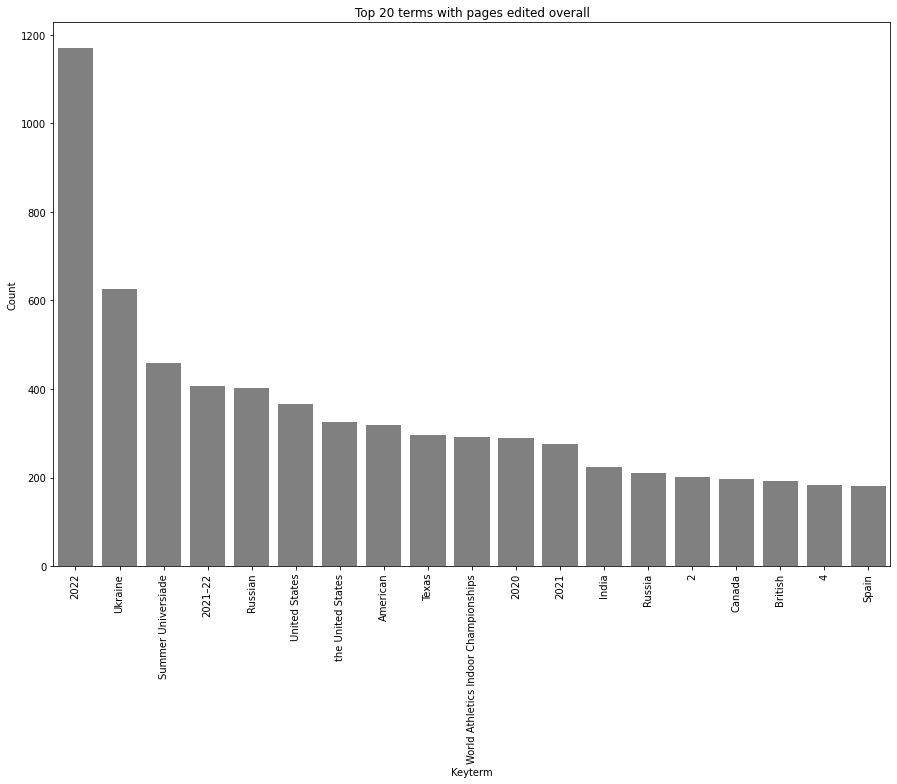

In [9]:
plt.figure(figsize=(15,10))

ax = sns.barplot(
    data = ner_count_data[~ner_count_data['text'].str.contains('Wikipedia')][:20],
    x = 'text',
    y = 'count',
    ci = None,
    color = 'grey'
)

ax.set_ylabel('Count')
ax.set_xlabel('Keyterm')

ax.set_title(f'Top 20 terms with pages edited overall')
plt.xticks(rotation=90)
plt.show()

## Topic deep dive

### 2022

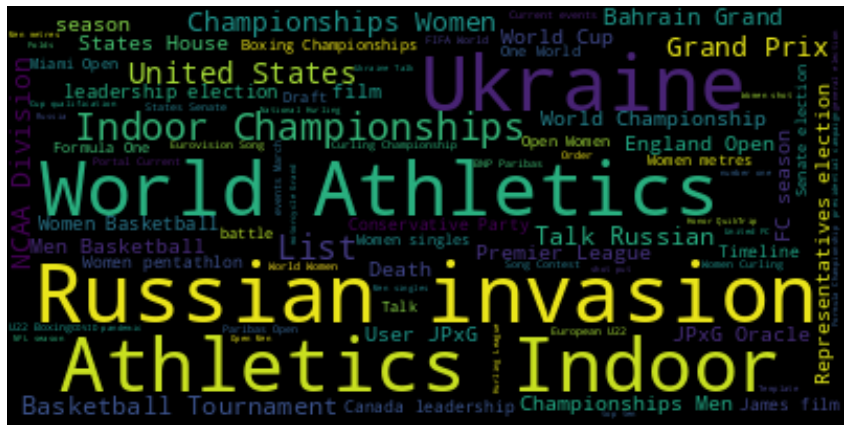

In [11]:
documents = data[(data['page_title'].str.contains('2022')) & (~data['page_title'].str.contains('Wikipedia'))]['page_title'].values.tolist()

generate_wordcloud(documents)

In [12]:
data[(data['page_title'].str.contains('2022')) & (~data['page_title'].str.contains('Wikipedia'))]['page_title'].value_counts()[:20]

Talk:2022 Russian invasion of Ukraine                             115
2022 Bahrain Grand Prix                                           106
User:JPxG/Oracle/2022-03                                           81
2022 Russian invasion of Ukraine                                   77
2022 All England Open                                              71
2022 NCAA Division I Men's Basketball Tournament                   69
2022 World Athletics Indoor Championships – Women's pentathlon     56
2022 NCAA Division I Women's Basketball Tournament                 56
2022 World Athletics Indoor Championships                          55
James (2022 film)                                                  52
2022 Conservative Party of Canada leadership election              43
2022 World Women's Curling Championship                            42
2022 European U22 Boxing Championships                             41
Deaths in 2022                                                     38
Order of battle for 

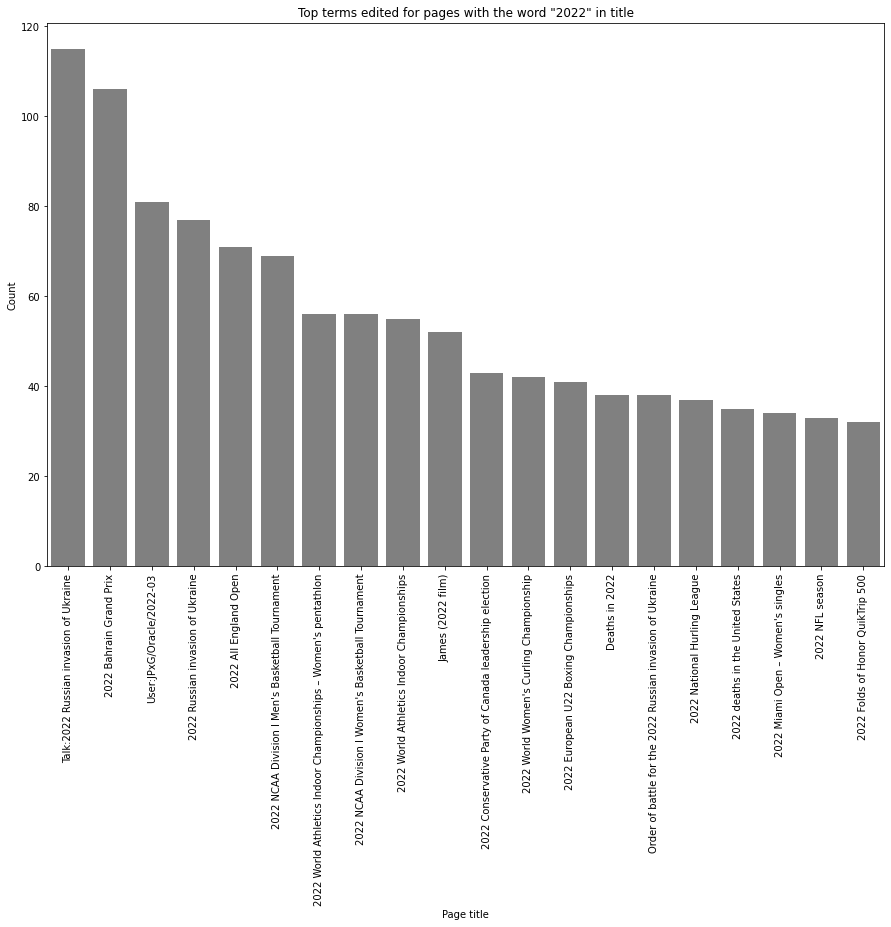

In [13]:
sports_edit_data = data[(data['page_title'].str.contains('2022')) & (~data['page_title'].str.contains('Wikipedia'))]['page_title'].value_counts().to_frame().reset_index()

plt.figure(figsize=(15,10))
ax = sns.barplot(
    data = sports_edit_data[:20],
    x = 'index',
    y = 'page_title',
    color = 'grey'
)

ax.set_title(f'Top terms edited for pages with the word "2022" in title')
ax.set_ylabel('Count')
ax.set_xlabel('Page title')
plt.xticks(rotation=90)
plt.show()

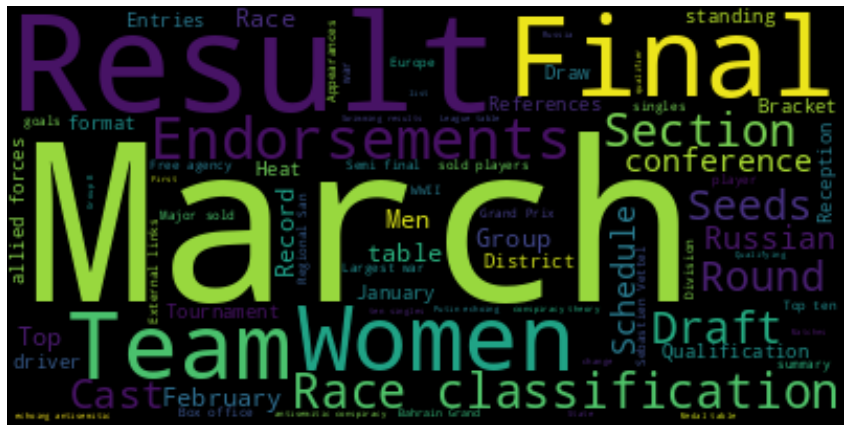

In [14]:
documents = data[(data['page_title'].str.contains('2022')) & (~data['page_title'].str.contains('Wikipedia')) & (~data['section'].isna()) & (~data['section'].str.contains('edit|content', na = False))]['section'].values.tolist()

generate_wordcloud(documents)

### Ukraine

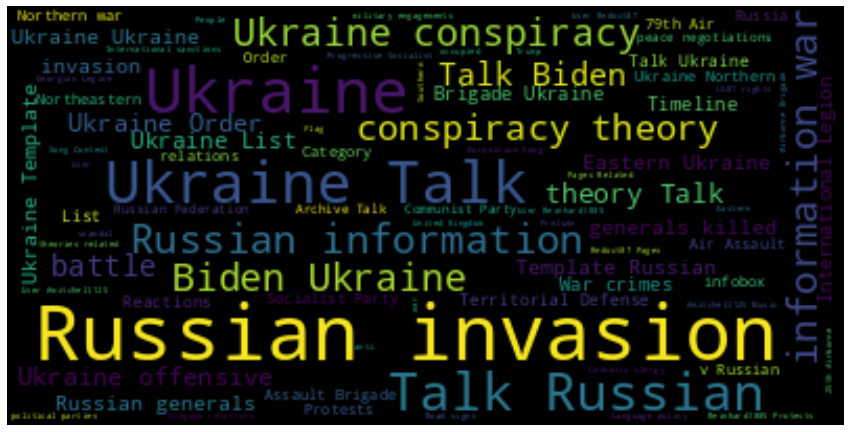

In [15]:
documents = data[(data['page_title'].str.contains('Ukraine')) & (~data['page_title'].str.contains('Wikipedia'))]['page_title'].values.tolist()

generate_wordcloud(documents)

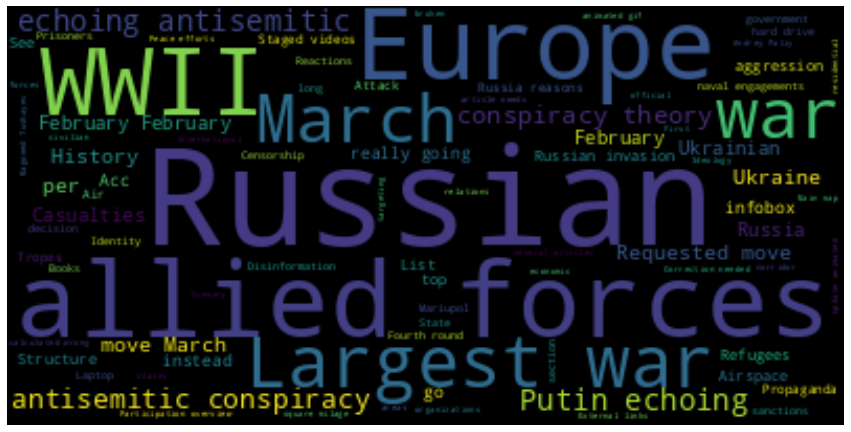

In [16]:
documents = data[(data['page_title'].str.contains('Ukraine')) & (~data['page_title'].str.contains('Wikipedia')) & (~data['section'].isna()) & (~data['section'].str.contains('edit|content', na = False))]['section'].values.tolist()

generate_wordcloud(documents)

### Texas

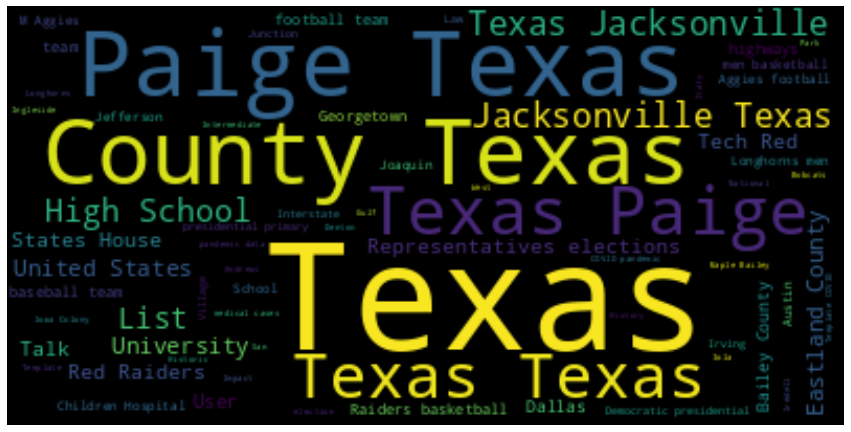

In [17]:
documents = data[(data['page_title'].str.contains('Texas')) & (~data['page_title'].str.contains('Wikipedia'))]['page_title'].values.tolist()

generate_wordcloud(documents)

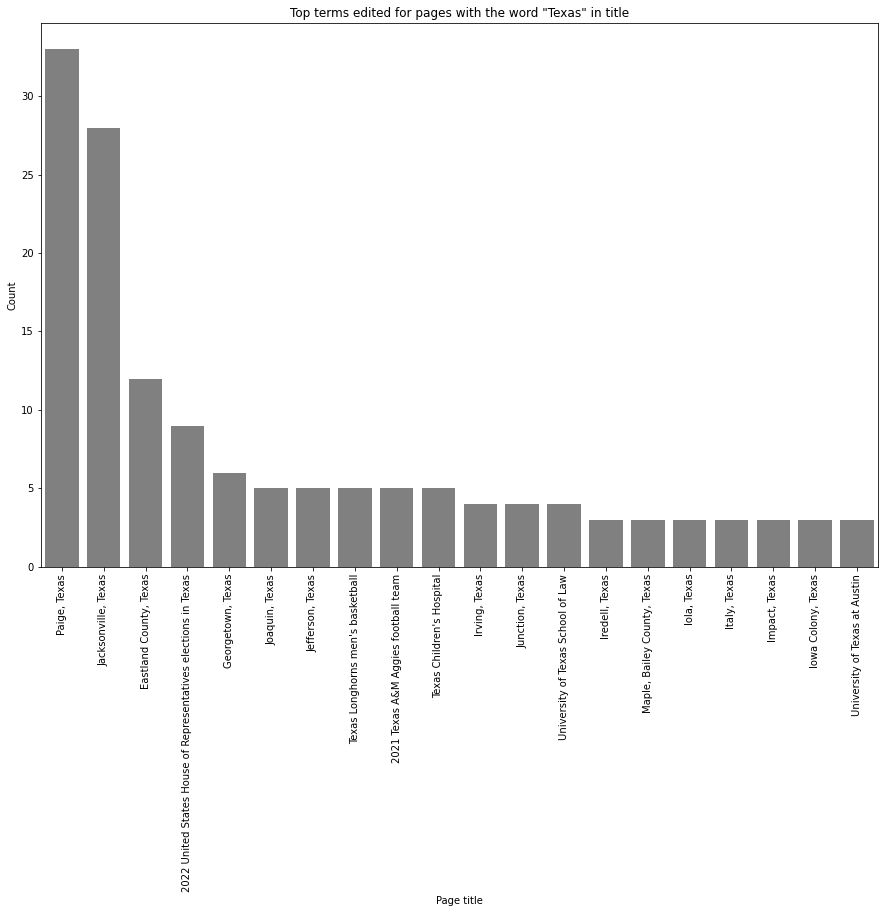

In [18]:
texas_edit_data = data[(data['page_title'].str.contains('Texas')) & (~data['page_title'].str.contains('Wikipedia'))]['page_title'].value_counts().to_frame().reset_index()

plt.figure(figsize=(15,10))
ax = sns.barplot(
    data = texas_edit_data[:20],
    x = 'index',
    y = 'page_title',
    color = 'grey'
)

ax.set_title(f'Top terms edited for pages with the word "Texas" in title')
ax.set_ylabel('Count')
ax.set_xlabel('Page title')
plt.xticks(rotation=90)
plt.show()

In [19]:
jacksonville_data = data[(data['page_title'].str.contains('Jacksonville, Texas')) & (~data['page_title'].str.contains('Wikipedia')) & (~data['parsed_summary'].isna())][['page_title', 'user', 'parsed_summary']]

print(f'Number of unique users who edited wikipedia page on Jacksonville: {jacksonville_data.user.nunique()} \n')
print('Edit summarys:')
print(jacksonville_data.parsed_summary.value_counts())

Number of unique users who edited wikipedia page on Jacksonville: 1 

Edit summarys:
format fix (comma)        22
rm dated tag re:10/'17     1
rm editorial line          1
rm dated tag re:11/'12     1
comma                      1
en dash                    1
rm period                  1
Name: parsed_summary, dtype: int64


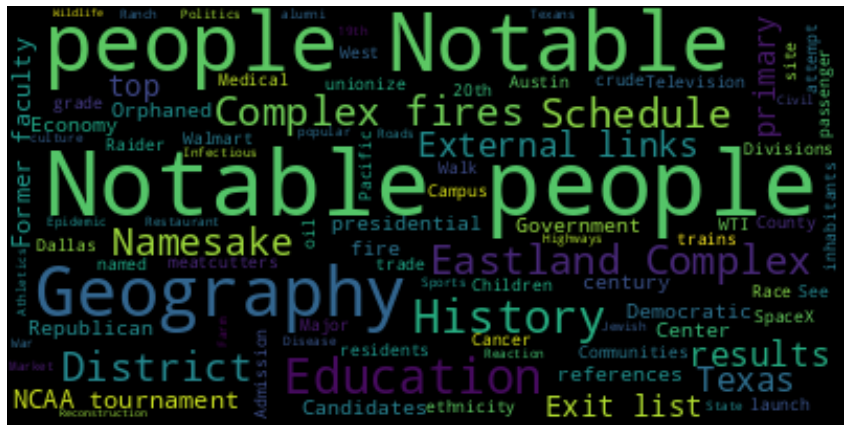

In [20]:
documents = data[(data['page_title'].str.contains('Texas')) & (~data['page_title'].str.contains('Wikipedia')) & (~data['section'].isna()) & (~data['section'].str.contains('edit|content', na = False))]['section'].values.tolist()

generate_wordcloud(documents)